In [1]:
#import numpy as np
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

# 1. Fake data

In [ ]:
M = 200
N = 50

X = np.linspace(0, 1, M)
Y = np.linspace(0, 1, N)
XX, YY = np.meshgrid(X, Y)

In [ ]:
def f1(x): return np.sqrt(-x**2*(x-1/2)**2*(x-1))

plt.plot(X, f1(X))

In [ ]:
c = 0.7
def f2(y): return -abs(y-c) + c

plt.plot(Y, f2(Y))

In [ ]:
def γ(x,y): return f1(x)*f2(y)

Γ = γ(XX,YY)
plt.imshow(Γ)

In [ ]:
def d(x,p): return cp.norm(x-p)
def d_(x,p): return np.linalg.norm(x-p)

x = np.array([1/3,1/4])
D = [d_(x,(X[i],Y[j])) for i in range(M) for j in range(N)]

plt.imshow(np.transpose(np.reshape(D, (M, N))))

In [ ]:
#k = 3
#def s(d): return cp.exp(-k*d)
#def s_(d): return np.exp(-k*d)
def s(d): return -d
def s_(d): return -d

S = [s_(d_(x,(X[i],Y[j]))) for i in range(M) for j in range(N)]

plt.imshow(np.transpose(np.reshape(S, (M, N))))

In [ ]:
SΓ = [s_(d_(x,(X[i],Y[j])))*γ(X[i],Y[j]) for i in range(M) for j in range(N)]

plt.imshow(np.transpose(np.reshape(SΓ, (M, N))))

In [ ]:
x_pb = cp.Variable(2)
f_obj = cp.sum([s(d(x_pb,(X[i],Y[j])))*γ(X[i],Y[j]) for i in range(M) for j in range(N)])

In [ ]:
f_obj

In [ ]:
pb = cp.Problem(cp.Maximize(f_obj), [x_pb[0] >= 0, x_pb[1] >= 0, x_pb[0] <= 1, x_pb[1] <= 1])

In [ ]:
pb.solve()

In [ ]:
x_pb.value

In [ ]:
plt.imshow(Γ)
plt.plot(x_pb.value[0]*M, x_pb.value[1]*N, marker = '^', color = 'red')

In [ ]:
k = 3
def s(d): return cp.exp(-k*d)
def s_(d): return np.exp(-k*d)
#def s(d): return -d
#def s_(d): return -d

S = [s_(d_(x,(X[i],Y[j]))) for i in range(M) for j in range(N)]

plt.imshow(np.transpose(np.reshape(S, (M, N))))

# 2: Real-world data

- We will use real-world demographic data taken from LandScan [1].


- The desired information pertaining to the population of the city of Rio de Janeiro has been extracted by the ModSiming team from UFRJ [2].

[1] https://landscan.ornl.gov/

[2] https://github.com/ModSiming/EpiSiming

## 2.1: Data

In [2]:
landscan_rio = np.load('landscan_rio_paqueta.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)
landscan_rio_xscale = 0.85239
landscan_rio_yscale = 0.926
landscan_rio_ydim, landscan_rio_xdim = landscan_rio.shape
landscan_rio_xextent = landscan_rio_xdim*landscan_rio_xscale
landscan_rio_yextent = landscan_rio_ydim*landscan_rio_yscale

print(f'Dimensão da matriz de blocos: {landscan_rio.shape}')
print('Região representada pelo LandScan: ',
      f'{landscan_rio_xextent:.3f} x {landscan_rio_yextent:.3f} km^2')
print(f'Total de blocos: {landscan_rio_xdim*landscan_rio_ydim}')
print(f'Total de blocos habitados: {len(landscan_rio[landscan_rio>0])}')
print(f'População: {landscan_rio.sum()}')

Dimensão da matriz de blocos: (39, 83)
Região representada pelo LandScan:  70.748 x 36.114 km^2
Total de blocos: 3237
Total de blocos habitados: 1473
População: 6860819


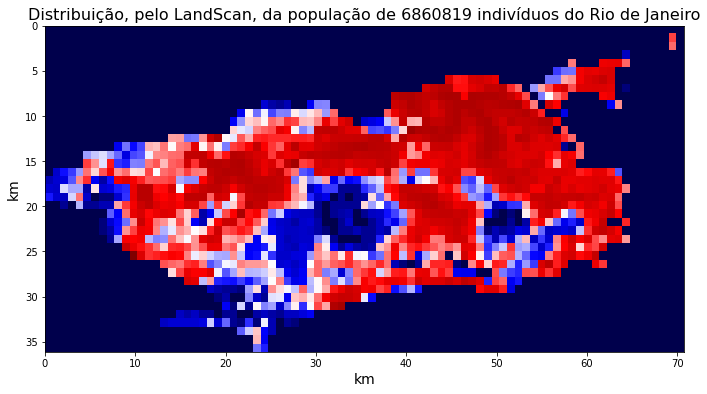

In [124]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio), cmap='seismic', interpolation='none',
           extent=[0, landscan_rio_xextent, landscan_rio_yextent, 0])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Distribuição, pelo LandScan, da população de {int(landscan_rio.sum())} indivíduos do Rio de Janeiro',
          fontsize=16)
plt.show()

## 2.2: Linear signal decay (concave objective function)

In [ ]:
var = cp.Variable(2)

res_x_1 = (var[0] >= 0); res_x_2 = (var[0] <= landscan_rio_xdim-1)
res_y_1 = (var[1] >= 0); res_y_2 = (var[1] <= landscan_rio_ydim-1)
res = [res_x_1, res_x_2, res_y_2, res_y_2]

def d(p,q): return cp.norm(p-q)
def s(d): return -d

f_obj = cp.sum([s(d(var,[x,y])) * landscan_rio[y,x] for x in range(landscan_rio_xdim) for y in range(landscan_rio_ydim)])

pb = cp.Problem(cp.Maximize(f_obj), res)
pb.solve()

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio), cmap = 'seismic')
plt.plot(var[0].value, var[1].value, '^', color = 'lime', markersize = 10, label = "Antenna placement")
plt.title("Optimal antenna placement in Rio de Janeiro (linear signal decay)", fontsize = 20, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

## 2.3: Exponential signal decay (non-convex/concave objetive funtion)

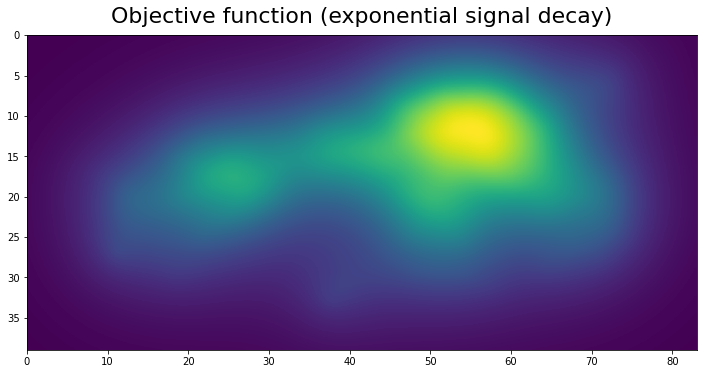

In [125]:
def d(p,q): return np.linalg.norm(p-q, axis = 1)
c = 0.25
def s(d): return np.exp(-c*d)

pts_x = np.array(range(landscan_rio_xdim))
pts_y = np.array(range(landscan_rio_ydim))
pts_x_meshgrid, pts_y_meshgrid = np.meshgrid(pts_x, pts_y)
all_pts = np.column_stack((pts_x_meshgrid.ravel(), pts_y_meshgrid.ravel()))
    
def f_original(p): return np.sum(s(d(p,all_pts)) * landscan_rio.ravel())

M = 200
N = 200
X = np.linspace(0, landscan_rio_xdim, M)
Y = np.linspace(0, landscan_rio_ydim, N)

F = np.reshape([f_original(np.array([x,y])) for y in Y for x in X], (M,N))

plt.figure(figsize=(12,6))
plt.imshow(F, extent = [0, landscan_rio_xdim, landscan_rio_ydim, 0])
plt.title("Objective function (exponential signal decay)", fontsize = 22, y = 1.02);

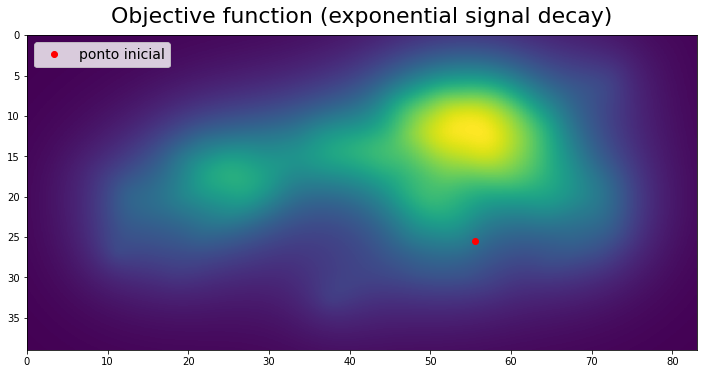

In [129]:
pt_inicial = np.array([55.5,25.5])

plt.figure(figsize=(12,6))
plt.imshow(F, extent = [0, landscan_rio_xdim, landscan_rio_ydim, 0])
plt.plot(pt_inicial[0], pt_inicial[1], 'o', color = 'red', label = "ponto inicial")
plt.title("Objective function (exponential signal decay)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

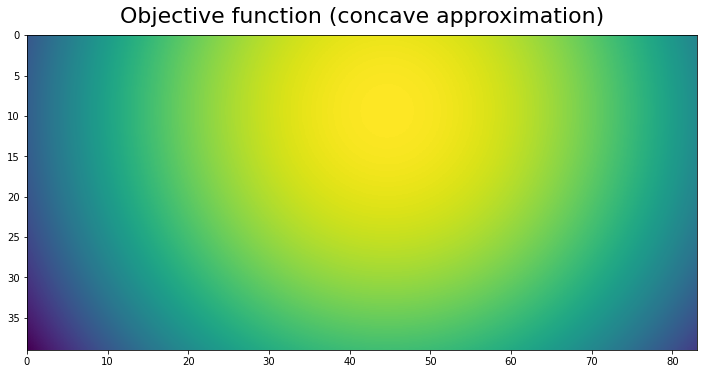

In [130]:
f_original_pt_inicial = f_original(pt_inicial)
g = grad(f_original)(pt_inicial)
R = 1_000.

def f_ccv_approx(p): return f_original_pt_inicial + g@(p - pt_inicial) - R*np.inner(p - pt_inicial, p - pt_inicial)
A = np.reshape([f_ccv_approx(np.array([x,y])) for y in Y for x in X], (N,M))

plt.figure(figsize=(12,6))
plt.imshow(A, extent = [0, landscan_rio_xdim, landscan_rio_ydim, 0])
plt.title("Objective function (concave approximation)", fontsize = 22, y = 1.02);

In [131]:
var = cp.Variable(2)

res_x_1 = (var[0] >= 0); res_x_2 = (var[0] <= landscan_rio_xdim-1)
res_y_1 = (var[1] >= 0); res_y_2 = (var[1] <= landscan_rio_ydim-1)
res = [res_x_1, res_x_2, res_y_1, res_y_2]

f_ccv_approx = f_original_pt_inicial + g@(var - pt_inicial) - R*cp.sum_squares(var - pt_inicial)
f_ccv_approx

Expression(CONCAVE, UNKNOWN, ())

In [132]:
var.value = [1.,1.]
f_ccv_approx.value

-1276914.743760753

In [133]:
var.value = [50.,35.]
f_ccv_approx.value

9908.191413791123

In [134]:
var.value = [50.,1.]
f_ccv_approx.value

599115.6247164956

In [135]:
exp = var[0] + var[1]
exp.value

51.0

In [136]:
var.value = [1.,1.]
exp.value

2.0

In [137]:
pb = cp.Problem(cp.Maximize(f_ccv_approx), res)
pb.solve()

697286.5899585979

In [138]:
var.value

array([44.64316703,  9.3351848 ])

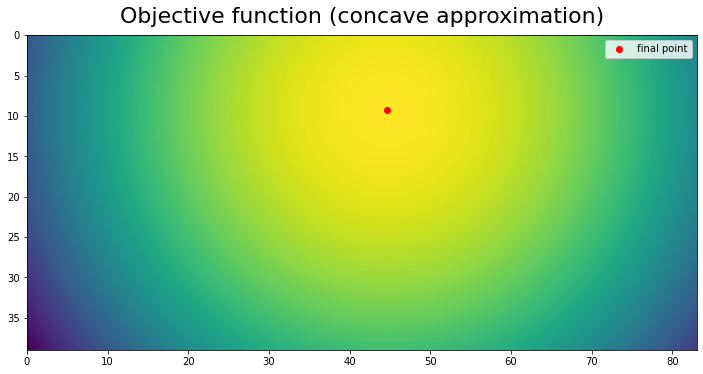

In [140]:
plt.figure(figsize=(12,6))
plt.imshow(A, extent = [0, landscan_rio_xdim, landscan_rio_ydim, 0])
plt.plot(var.value[0], var.value[1], 'o', color = 'red', label = "final point")
plt.title("Objective function (concave approximation)", fontsize = 22, y = 1.02)
plt.legend();

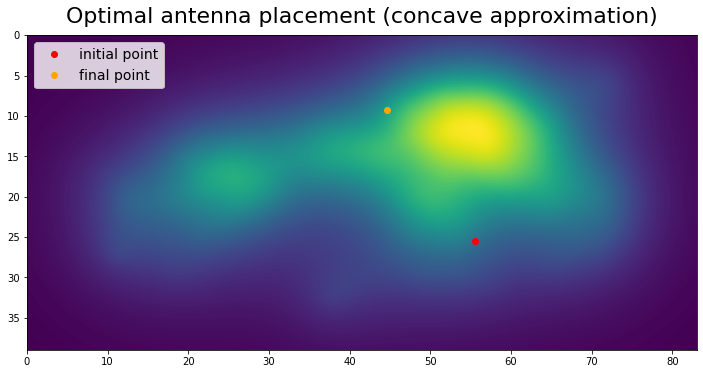

In [142]:
plt.figure(figsize=(12,6))
plt.imshow(F, extent = [0, landscan_rio_xdim, landscan_rio_ydim, 0])
plt.plot(pt_inicial[0], pt_inicial[1], 'o', color = 'red', label = "initial point")
plt.plot(var.value[0], var.value[1], 'o', color = 'orange', label = "final point")
plt.title("Optimal antenna placement (concave approximation)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);